In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import shap

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site

In [3]:
# File paths for signal and background root files: 
photon_PU0 = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/photons_0PU_bc_stc_hadd.root"
photon_PU200_gen = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered.h5"
photon_PU200_cl3d = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered.h5"
neutrino_PU200_cl3d = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered_neutrino.h5"

In [4]:
signal_file = uproot.open(photon_PU0)
signal_folder = "FloatingpointMixedbcstcrealsig4DummyHistomaxxydr015GenmatchGenclustersntuple"
#bg_folder = "l1tHGCalTriggerNtuplizer"
tree_name = "HGCalTriggerNtuple"
signal_tree_path = f"{signal_folder}/{tree_name}"

# Access the signal tree in ROOT (uproot)
signal_tree = signal_file[signal_tree_path]

In [5]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)

In [6]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    # Ensure required columns are present
    required_columns = ['cl3d_eta', 'cl3d_phi', 'genpart_exeta', 'genpart_exphi']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    # Calculate delta_r and add it as a column
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    
    # Filter the DataFrame
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    return df_filtered

In [7]:
# Function to load and filter the tree data (for ROOT file)
def load_and_filter_tree(tree, filter_pt = 20, eta_range=(1.6, 2.8), cl_pt_threshold=5):
    df_gen = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["gen_n", "gen_eta", "gen_phi", "gen_pt", 
                     "genpart_exeta", "genpart_exphi", "event"]
    ))
    df_cl3d = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["*cl3d*", "event"]
    ))
    df_gen_filtered = df_gen[(df_gen['gen_pt'] > filter_pt) & 
                     (abs(df_gen['gen_eta']) > eta_range[0]) & 
                     (abs(df_gen['gen_eta']) < eta_range[1])]
    df_cl3d_filtered = df_cl3d[(abs(df_cl3d['cl3d_eta']) > eta_range[0]) & 
                     (abs(df_cl3d['cl3d_eta']) < eta_range[1]) &
                     (df_cl3d['cl3d_pt'] > cl_pt_threshold)]
    merged_df = pd.merge(
        df_gen_filtered,
        df_cl3d_filtered,
        on="event",
        how="inner",  # Keep only rows where the event ID exists in both
        suffixes=('_gen', '_cl3d')  # Differentiate common column names
    )
    return merged_df

In [8]:
# Function to load and filter the tree data (for HDF file)
def load_and_filter_hdf(df_gen_path, df_cl3d_path):
    if df_gen_path == 'None':
        df_cl3d = pd.read_hdf(df_cl3d_path)
        return df_cl3d 
 
    else:
        df_gen = pd.read_hdf(df_gen_path)
        df_cl3d = pd.read_hdf(df_cl3d_path)
        merged_df = pd.merge(
            df_gen,
            df_cl3d,
            on="event",
            how="inner",  # Keep only rows where the event ID exists in both
            suffixes=('_gen', '_cl3d')  # Differentiate common column names
        )
        return merged_df

In [9]:
photonPU0_df = load_and_filter_tree(signal_tree)

In [10]:
photonPU200_df = load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)

In [11]:
neutrinoPU200_df = load_and_filter_hdf('None', neutrino_PU200_cl3d)

In [12]:
photonPU0_df_filtered = filter_by_delta_r(photonPU0_df)

In [13]:
photonPU200_df_filtered = filter_by_delta_r(photonPU200_df)

In [14]:
def remove_duplicates(df):
    dfnoduplicates = df.drop_duplicates(subset=['cl3d_eta', 'cl3d_phi', 'cl3d_pt',
                                                'genpart_exeta', 'genpart_exphi','gen_pt'])
    return dfnoduplicates

In [15]:
photonPU0_df_noduplicates = remove_duplicates(photonPU0_df_filtered)
photonPU200_df_noduplicates = remove_duplicates(photonPU200_df_filtered)

In [16]:
photonPU0_df_noduplicates['delta_r']

2         0.004983
4         0.002175
10        0.010053
12        0.010174
18        0.000882
            ...   
505736    0.005258
505738    0.003237
505744    0.000510
505746    0.003807
505752    0.004063
Name: delta_r, Length: 125082, dtype: float32

In [18]:
photonPU200_df_noduplicates

,event,gen_n,gen_eta,gen_phi,gen_pt,genpart_exphi,genpart_exeta,cl3d_n,cl3d_id,cl3d_pt,...,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy,delta_r
134,124803,2,2.055631,2.070575,49.483158,2.070577,2.078856,180,2996610372,46.134079,...,8188,4080,0,10.438856,28.869230,0.996998,3,0.0,0.0,0.006945
210,124803,2,-2.055631,-1.071018,49.483158,-1.071020,-2.032983,180,3131482161,51.337742,...,8190,4088,0,11.685116,35.947742,0.998573,3,0.0,0.0,0.008725
362,124814,2,-1.644232,-0.910743,27.184336,-0.910732,-1.640322,158,3140944183,26.662031,...,3070,504,0,9.210422,21.678658,0.990855,3,0.0,0.0,0.002632
568,124814,2,1.644232,2.230849,27.184336,2.230837,1.648160,158,3005016084,16.595680,...,8180,4032,0,13.267605,31.814323,0.997962,3,0.0,0.0,0.013527
636,124817,2,-1.757209,2.993918,28.144424,2.993913,-1.740282,130,3139188483,28.266459,...,8186,4064,0,10.052516,25.538500,0.997962,3,0.0,0.0,0.004952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26078352,26880,2,-1.722336,-2.258044,42.800114,-2.258037,-1.717403,105,3139893335,42.698265,...,8191,4092,2228224,10.694054,28.575600,0.998573,3,0.0,0.0,0.000835
26078508,26866,2,2.432224,-1.177260,99.484673,-1.177238,2.422139,162,2988348262,110.887825,...,8190,4088,1441792,11.698406,41.289864,0.998573,3,0.0,0.0,0.001331
26078574,26866,2,-2.432224,1.964333,99.484673,1.964310,-2.442416,162,3122430307,104.427254,...,8190,4088,1146896,13.213321,45.576748,0.998062,3,0.0,0.0,0.001280
26078672,26869,2,-2.716381,-1.367809,78.825027,-1.367773,-2.708727,94,3122557236,91.472275,...,8191,4092,3474496,10.500427,48.846367,0.998785,3,0.0,0.0,0.006822


In [28]:
from mpl_toolkits.mplot3d import Axes3D

def plot_delta_r_3d_two_dfs(df, label, eta_col='cl3d_eta', energy_col='cl3d_energy', delta_r_col='delta_r', 
                            colors=('blue', 'red'), cmap = 'plasma', figsize=(12, 8)):
    # Ensure required columns are present
    required_columns = [eta_col, delta_r_col, energy_col]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    # Create the plot
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        df[eta_col], df[delta_r_col], c=df[energy_col], cmap=cmap, alpha=0.7, edgecolor='k', s=20
    )
    cbar = plt.colorbar(scatter, label=f"Energy [GeV]")
    # Set axis labels and title
    plt.xlabel("$\eta$ [rad]")
    plt.ylabel("$\Delta$ R [rad]")
    plt.title(f"$\Delta$ R vs $\eta$ for {label}")
    plt.tight_layout()
    filename = f"delta_r_vs_etaenergy_{label.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved plot as: {filename}")
    plt.show()

Saved plot as: delta_r_vs_etaenergy_photon_PU0.png


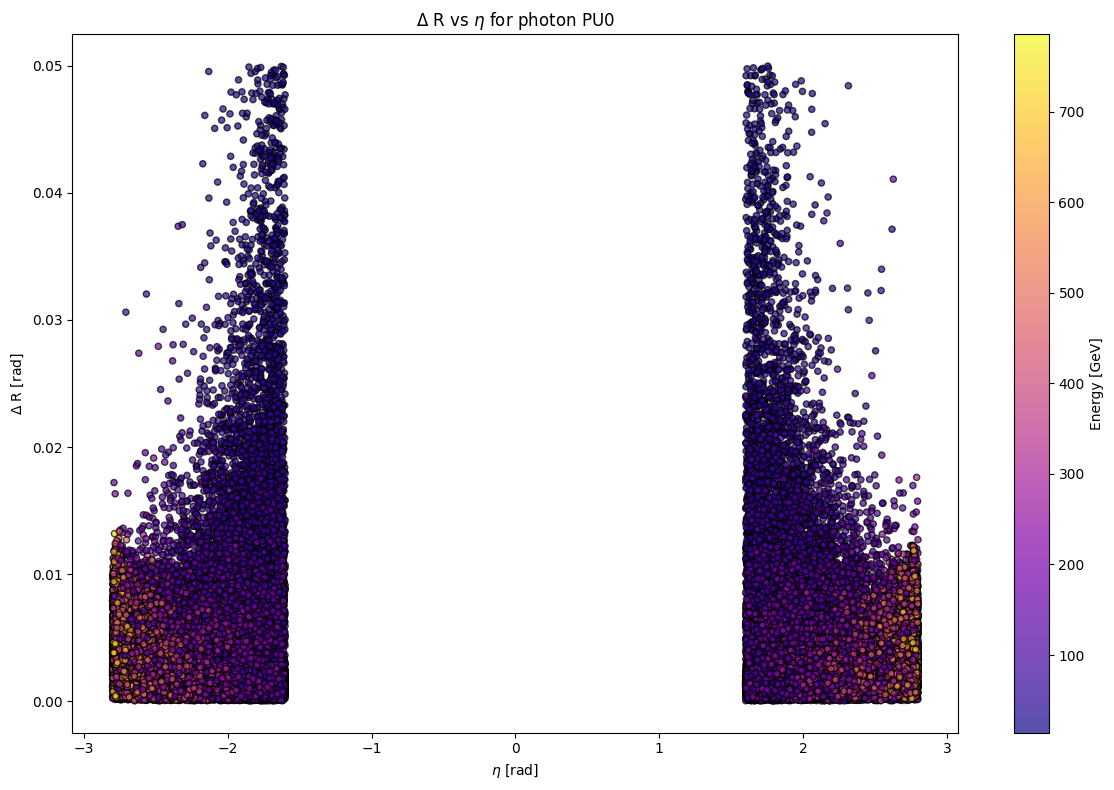

In [29]:
plot_delta_r_3d_two_dfs(photonPU0_df_noduplicates, 'photon PU0', colors=('blue', 'red'))

Saved plot as: delta_r_vs_etaenergy_photon_PU200.png


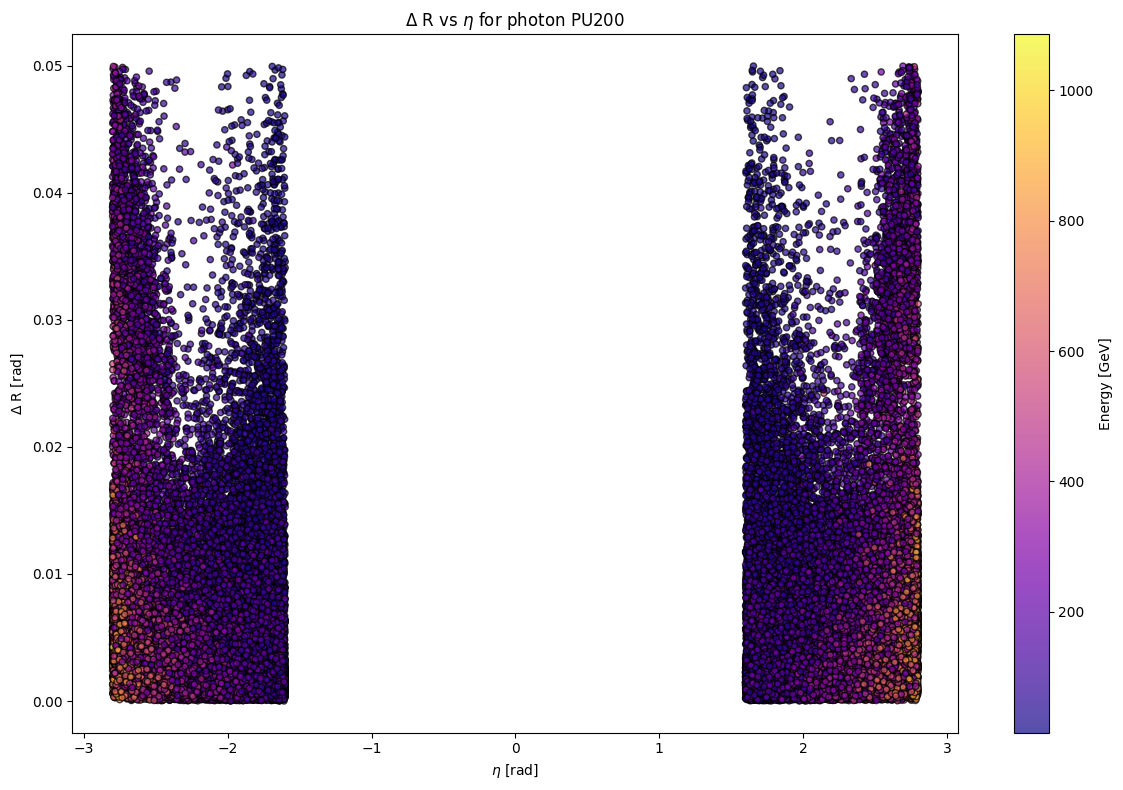

In [30]:
plot_delta_r_3d_two_dfs(photonPU200_df_noduplicates, 'photon PU200', colors=('blue', 'red'))

In [19]:
def plot_histograms(df_photon_no_pu, df_photon_pu200, df_neutrino_pu200, variables, num_bins=40, int_num_bins=10, cl3d_pt_range=(20, 30), figsize=(8, 4)):
    # Filter the DataFrames for cl3d_pt within the specified range
    df_photon_no_pu_filtered = df_photon_no_pu[(df_photon_no_pu['cl3d_pt'] >= cl3d_pt_range[0]) & (df_photon_no_pu['cl3d_pt'] <= cl3d_pt_range[1])]
    df_photon_pu200_filtered = df_photon_pu200[(df_photon_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_photon_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    df_neutrino_pu200_filtered = df_neutrino_pu200[(df_neutrino_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_neutrino_pu200['cl3d_pt'] <= cl3d_pt_range[1])]

    for var in variables:
        plt.figure(figsize=figsize)

        # Check if the column contains integer values
        if df_photon_no_pu_filtered[var].dtype in ['int64', 'int32']:
            # For integer columns, use integer binning
            min_value = min(
                df_photon_no_pu_filtered[var].min(),
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_no_pu_filtered[var].max(),
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            
            # Create bin edges for integer columns
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        else:
            # For non-integer columns, use a normal binning strategy
            min_value = min(
                df_photon_no_pu_filtered[var].min(),
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_no_pu_filtered[var].max(),
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)

        # Plot the histograms for all three datasets
        plt.hist(df_photon_no_pu_filtered[var], bins=bin_edges, color='g', alpha=0.5, label='Photon (0 PU)', edgecolor='black', density=True)
        plt.hist(df_photon_pu200_filtered[var], bins=bin_edges, color='b', alpha=0.5, label='Photon (200 PU)', edgecolor='black', density=True)
        plt.hist(df_neutrino_pu200_filtered[var], bins=bin_edges, color='r', alpha=0.5, label='Neutrino (200 PU)', edgecolor='black', density=True)
        
        # Set the plot title, labels, and legend
        plt.title(f"{var} Histogram (cl3d_pt between {cl3d_pt_range[0]} and {cl3d_pt_range[1]} GeV)")
        plt.xlabel(var)
        plt.ylabel('Normalized Frequency')
        plt.legend()

        # Adjust layout to prevent clipping
        plt.tight_layout()

        # Save the plot as a PNG file
        filename = f"{var}_histogram_cl3d_pt_{cl3d_pt_range[0]}_{cl3d_pt_range[1]}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")

        # Show the plot
        plt.show()

        # Close the plot to free memory
        plt.close()

In [24]:
variables = ['cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
       'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr',
       'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_hoe',
       'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',
       'cl3d_first1layers', 'cl3d_first3layers', 'cl3d_first5layers',
       'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers']

Saved: cl3d_pt_histogram_cl3d_pt_20_30.png


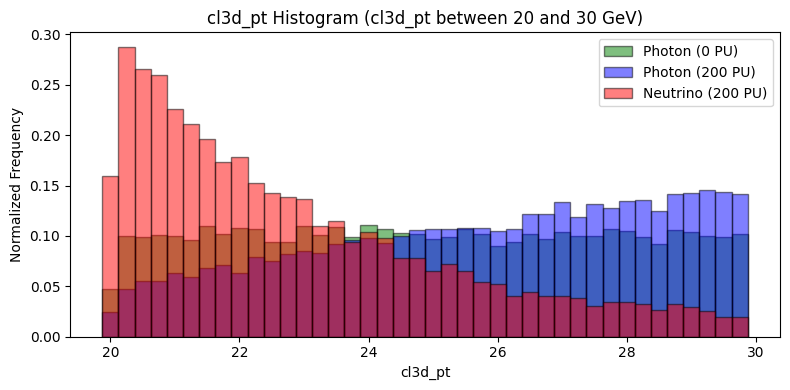

Saved: cl3d_energy_histogram_cl3d_pt_20_30.png


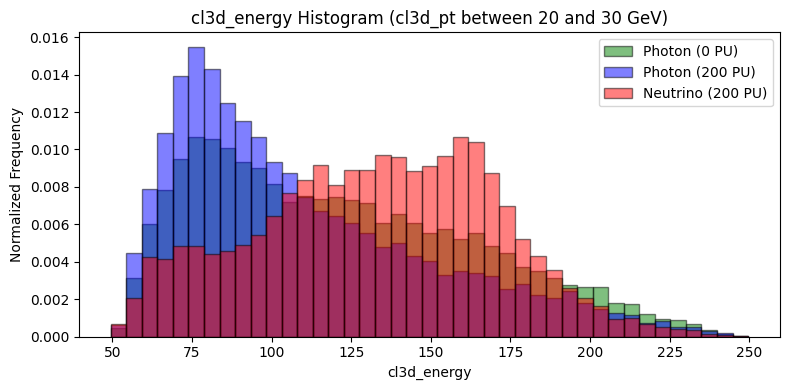

Saved: cl3d_eta_histogram_cl3d_pt_20_30.png


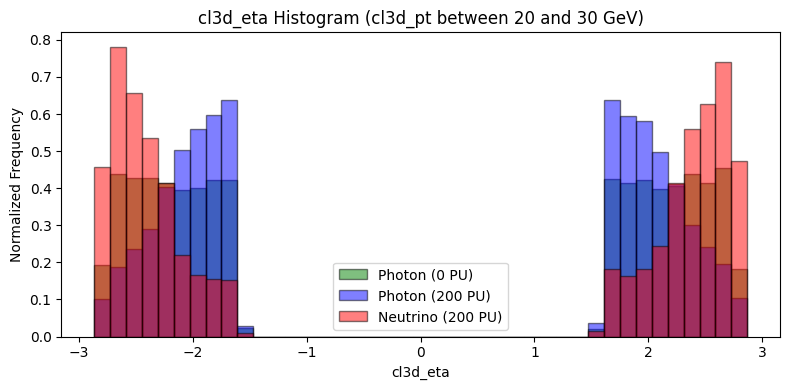

Saved: cl3d_phi_histogram_cl3d_pt_20_30.png


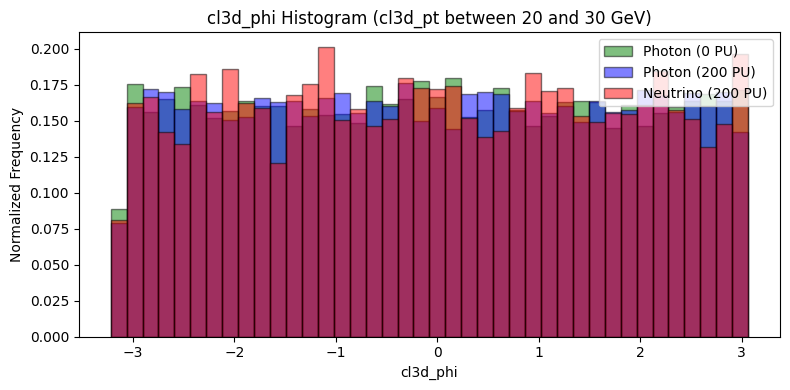

Saved: cl3d_showerlength_histogram_cl3d_pt_20_30.png


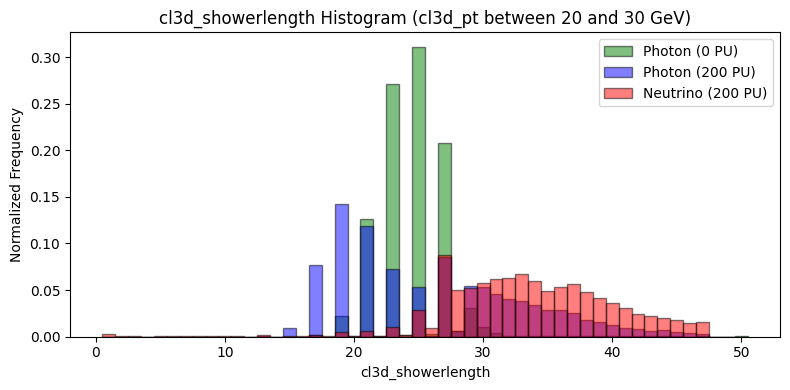

Saved: cl3d_coreshowerlength_histogram_cl3d_pt_20_30.png


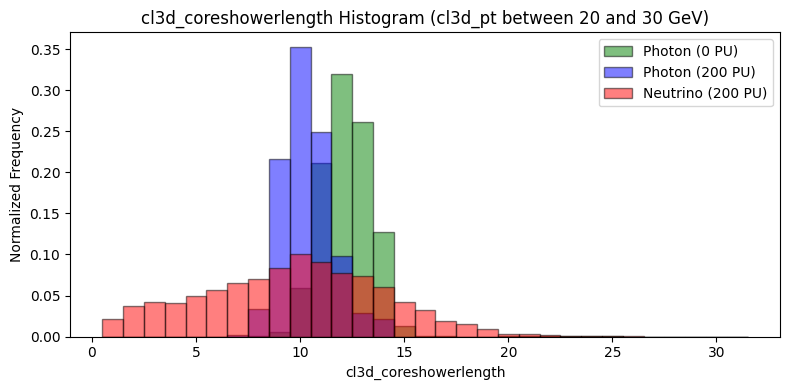

Saved: cl3d_firstlayer_histogram_cl3d_pt_20_30.png


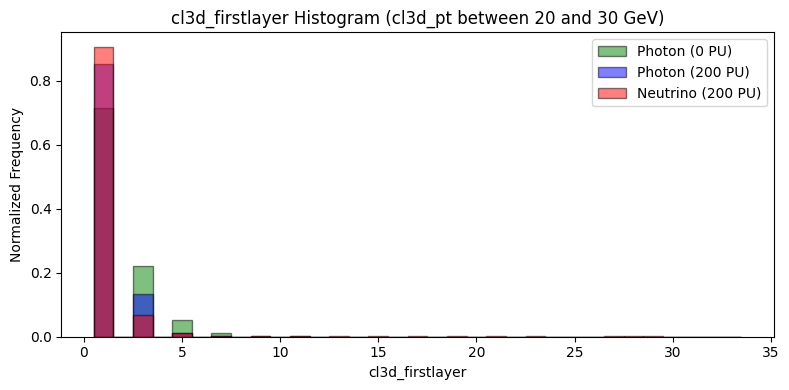

Saved: cl3d_maxlayer_histogram_cl3d_pt_20_30.png


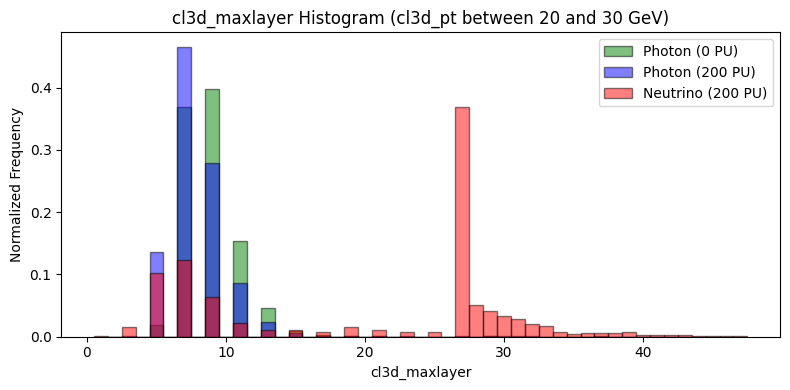

Saved: cl3d_seetot_histogram_cl3d_pt_20_30.png


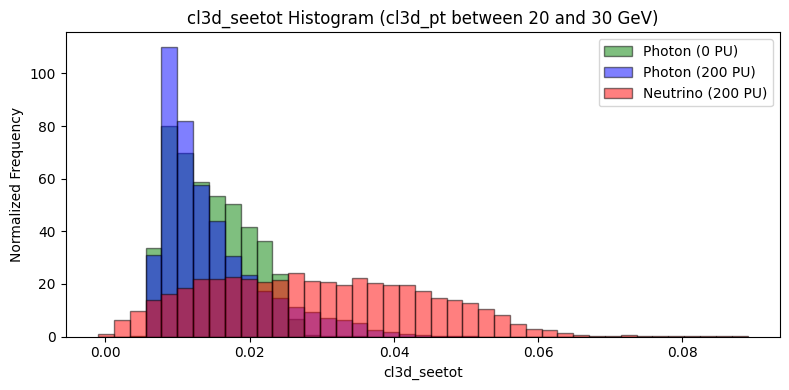

Saved: cl3d_seemax_histogram_cl3d_pt_20_30.png


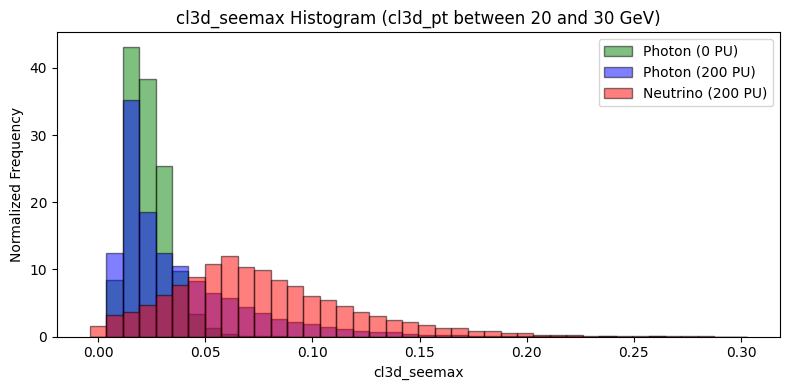

Saved: cl3d_spptot_histogram_cl3d_pt_20_30.png


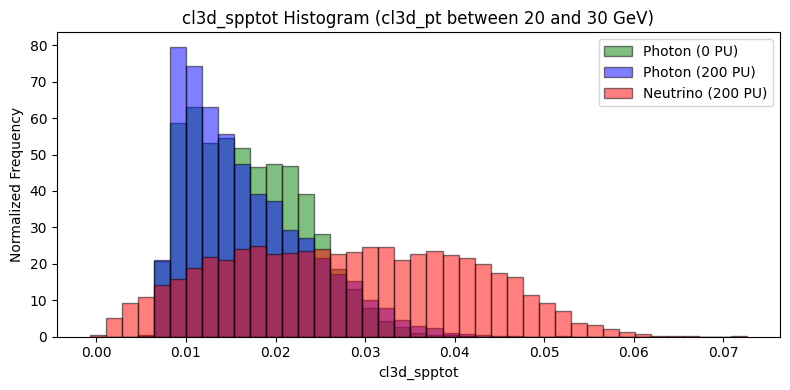

Saved: cl3d_sppmax_histogram_cl3d_pt_20_30.png


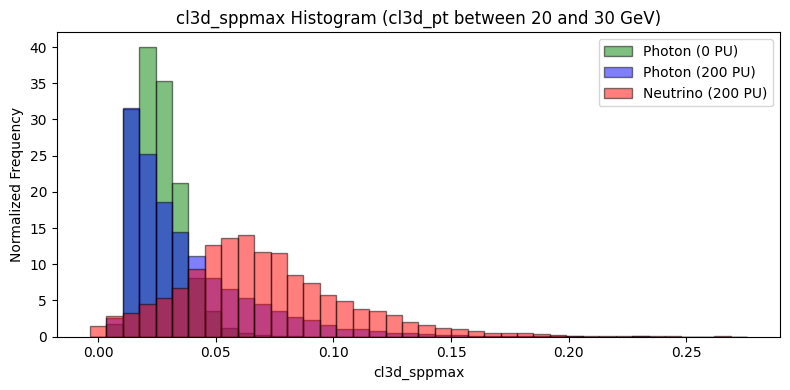

Saved: cl3d_szz_histogram_cl3d_pt_20_30.png


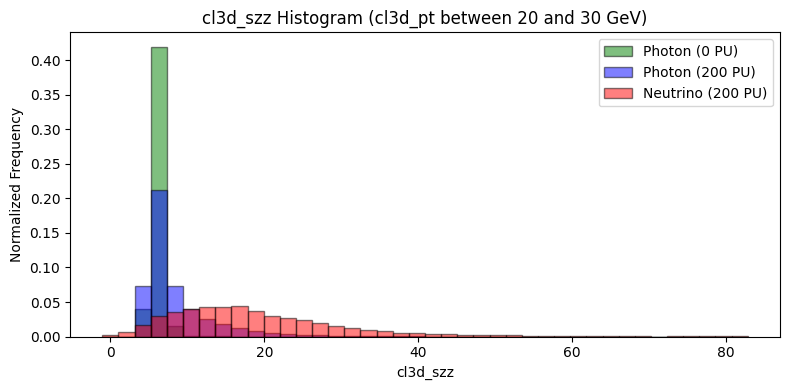

Saved: cl3d_srrtot_histogram_cl3d_pt_20_30.png


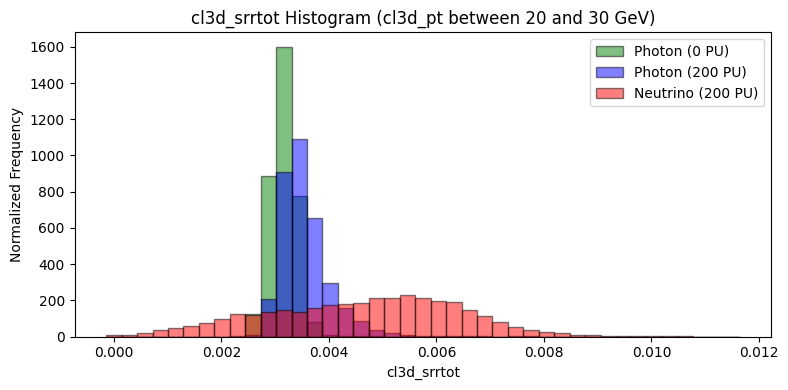

Saved: cl3d_srrmax_histogram_cl3d_pt_20_30.png


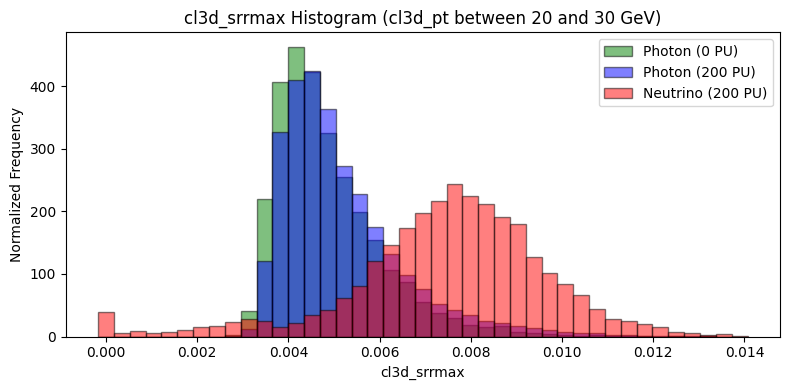

Saved: cl3d_srrmean_histogram_cl3d_pt_20_30.png


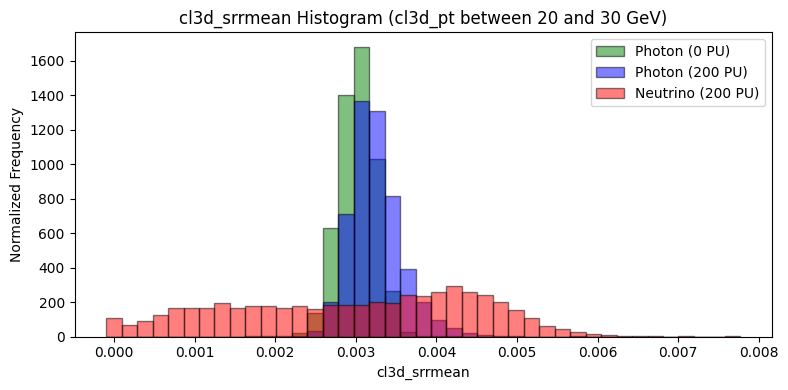

Saved: cl3d_varrr_histogram_cl3d_pt_20_30.png


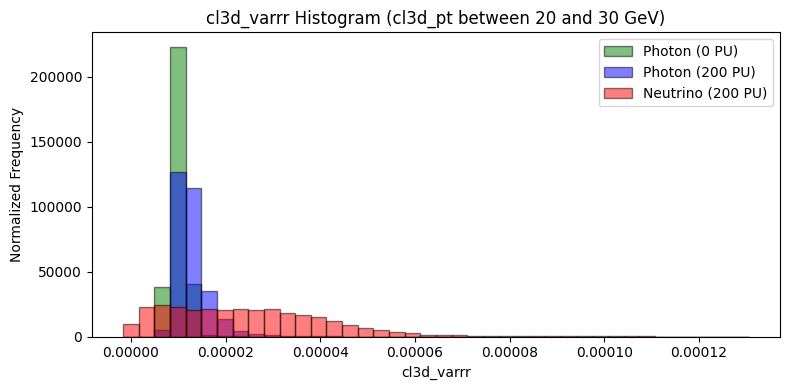

Saved: cl3d_varzz_histogram_cl3d_pt_20_30.png


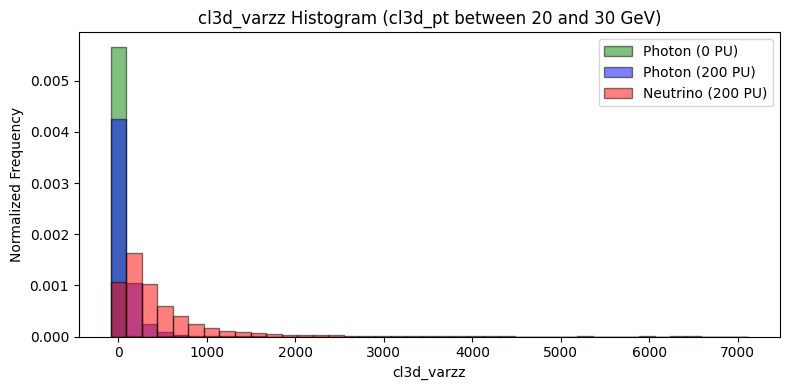

Saved: cl3d_varee_histogram_cl3d_pt_20_30.png


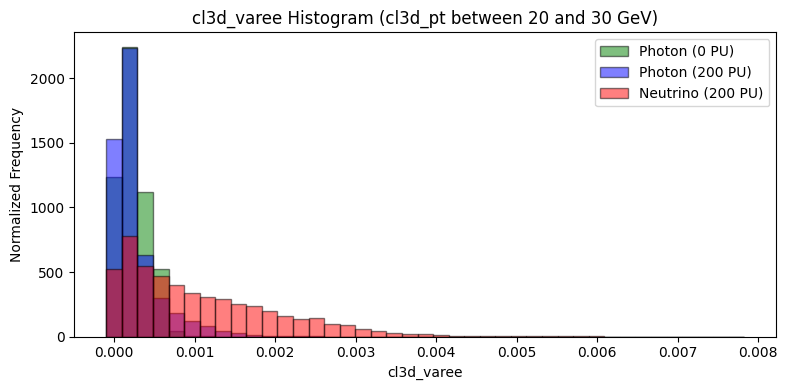

Saved: cl3d_varpp_histogram_cl3d_pt_20_30.png


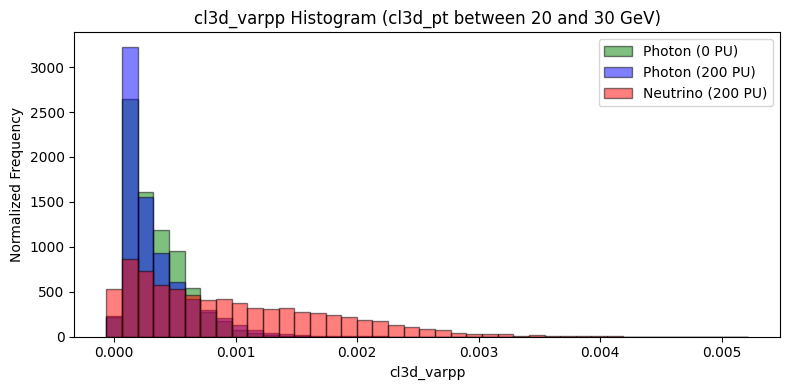

Saved: cl3d_emaxe_histogram_cl3d_pt_20_30.png


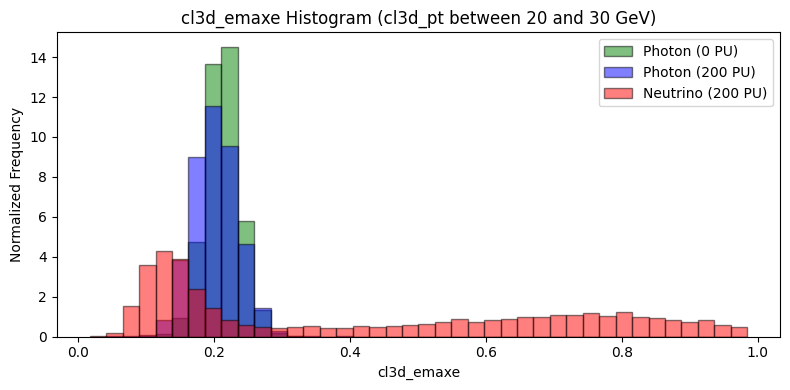

Saved: cl3d_hoe_histogram_cl3d_pt_20_30.png


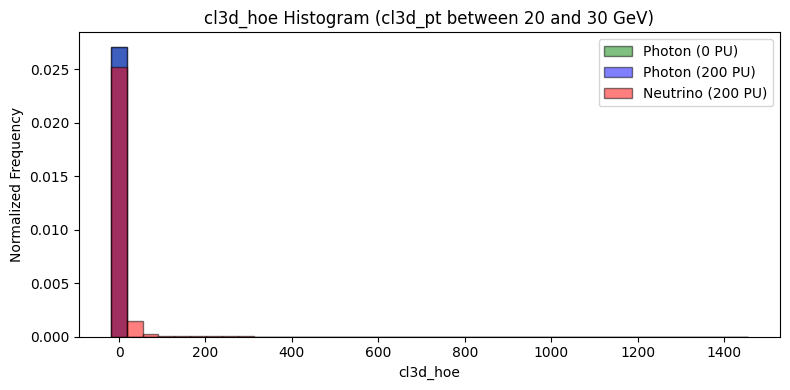

Saved: cl3d_meanz_histogram_cl3d_pt_20_30.png


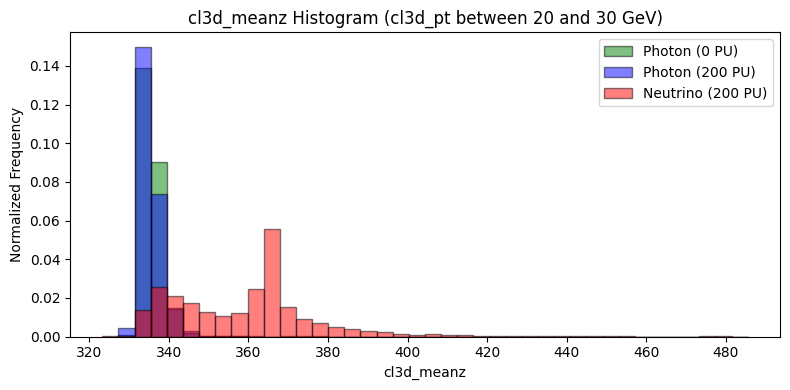

Saved: cl3d_layer10_histogram_cl3d_pt_20_30.png


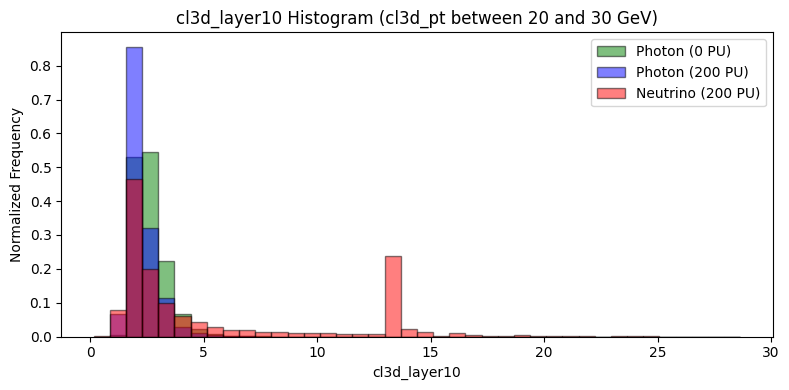

Saved: cl3d_layer50_histogram_cl3d_pt_20_30.png


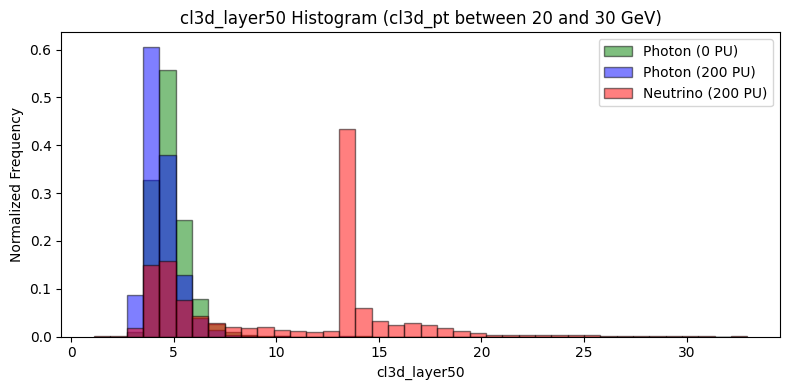

Saved: cl3d_layer90_histogram_cl3d_pt_20_30.png


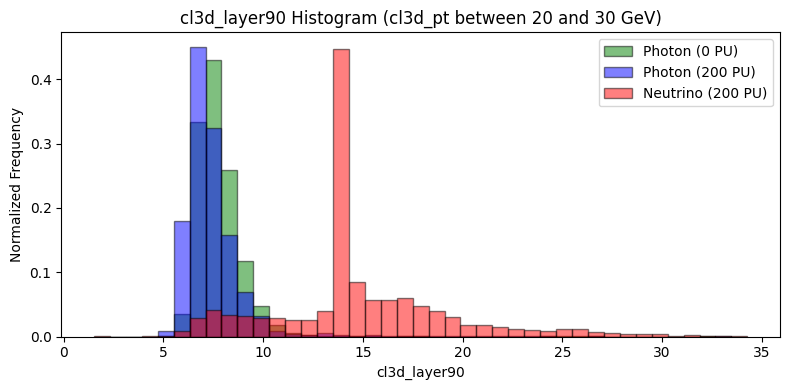

Saved: cl3d_first1layers_histogram_cl3d_pt_20_30.png


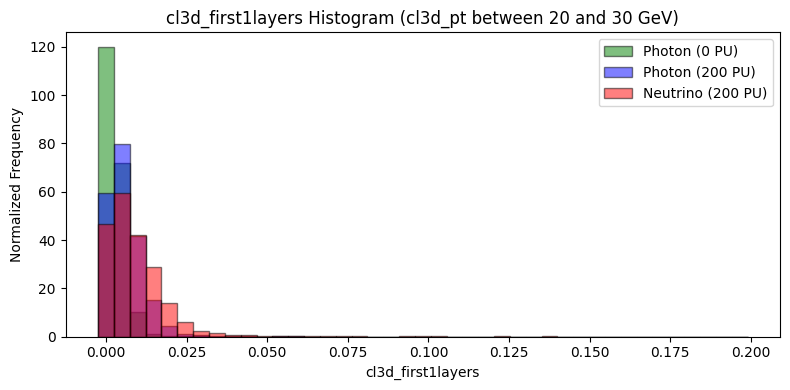

Saved: cl3d_first3layers_histogram_cl3d_pt_20_30.png


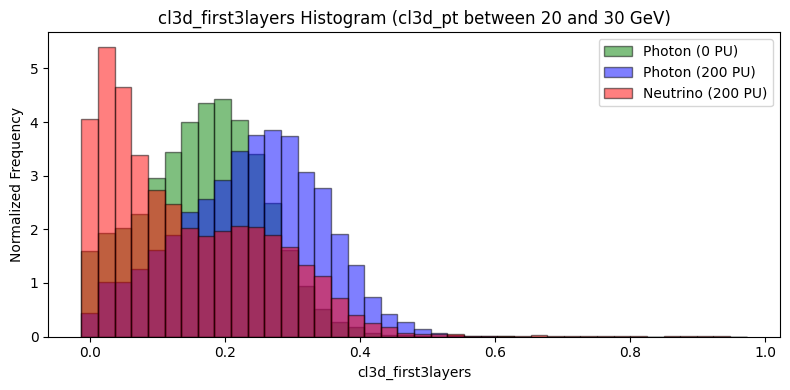

Saved: cl3d_first5layers_histogram_cl3d_pt_20_30.png


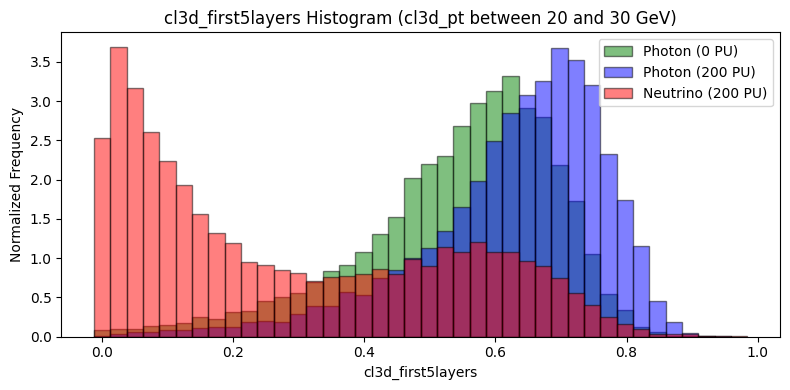

Saved: cl3d_firstHcal1layers_histogram_cl3d_pt_20_30.png


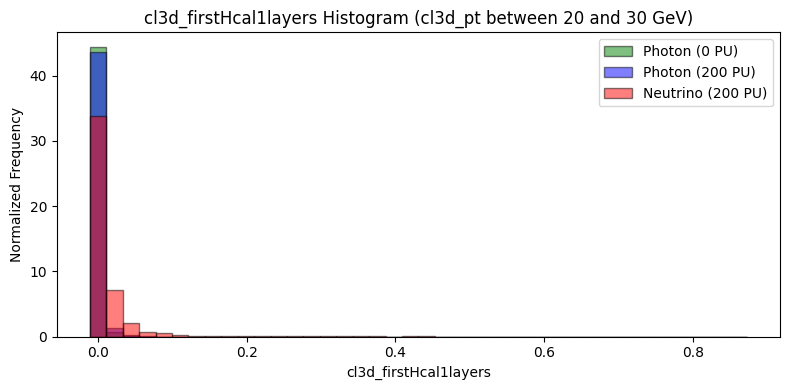

Saved: cl3d_firstHcal3layers_histogram_cl3d_pt_20_30.png


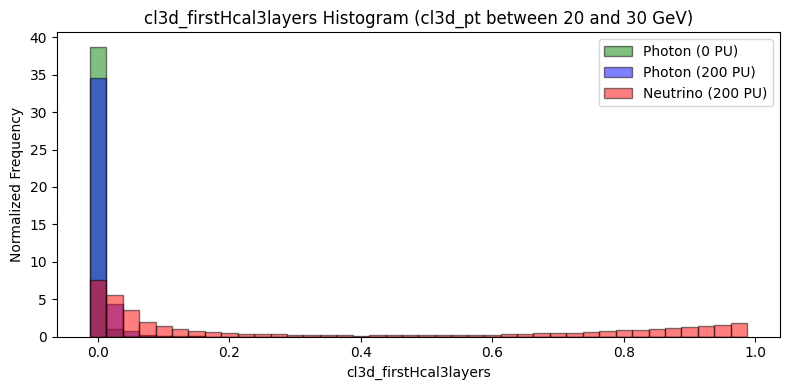

Saved: cl3d_firstHcal5layers_histogram_cl3d_pt_20_30.png


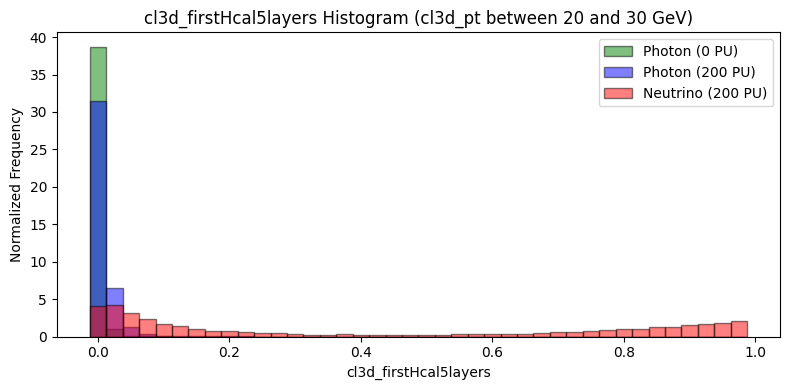

Saved: cl3d_last1layers_histogram_cl3d_pt_20_30.png


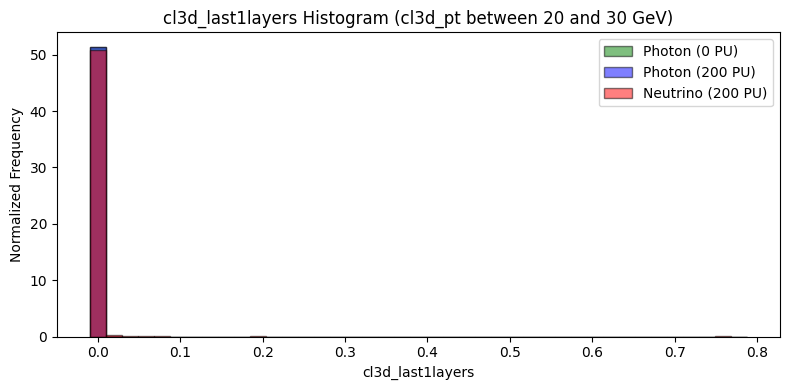

Saved: cl3d_last3layers_histogram_cl3d_pt_20_30.png


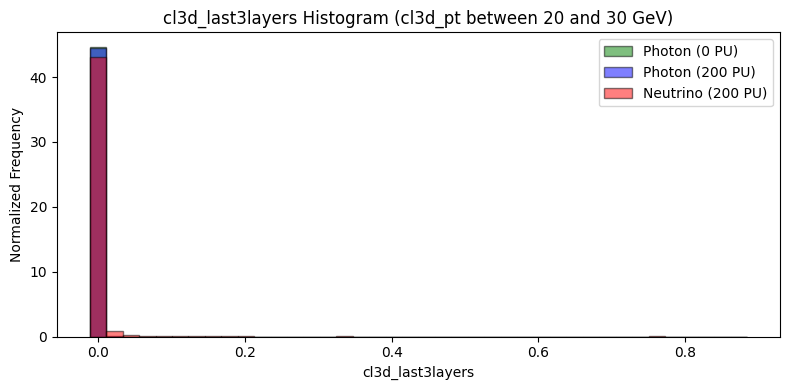

Saved: cl3d_last5layers_histogram_cl3d_pt_20_30.png


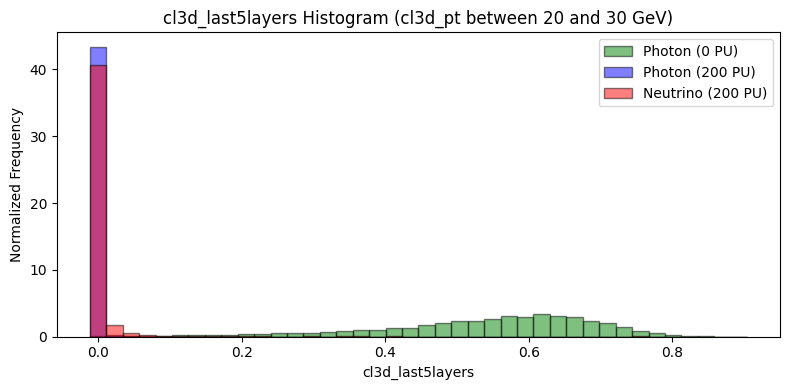

In [25]:
plot_histograms(photonPU0_df_noduplicates, photonPU200_df_noduplicates, neutrinoPU200_df, variables, cl3d_pt_range=(20, 30))

In [11]:
# Get the common columns between signal and background DataFrames
common_columns = df_signal_final_filtered.columns.intersection(bg_df_filtered.columns)

# Keep only the common columns in both DataFrames
df_signal_filtered_final = df_signal_final_filtered[common_columns]
df_bg_filtered_final = bg_df_filtered[common_columns]

# Display the columns to verify
print("Signal DataFrame columns after filtering:", df_signal_filtered_final.columns)
print("Background DataFrame columns after filtering:", df_bg_filtered_final.columns)

Signal DataFrame columns after filtering: Index(['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'genpart_exphi',
       'genpart_exeta', 'cl3d_n', 'cl3d_id', 'cl3d_pt', 'cl3d_energy',
       'cl3d_eta', 'cl3d_phi', 'cl3d_clusters_n', 'cl3d_clusters_id',
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_varrr', 'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe',
       'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_first1layers', 'cl3d_first3layers',
       'cl3d_first5layers', 'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers',
       'cl3d_emax5layers', 'cl3d_eot', 'cl3d_ebm0', 'cl3d_ebm1', 'cl3d_hbm',
       'cl3d_ntc67', 

In [12]:
# Add labels to signal (1) and background (0) DataFrames
df_signal_filtered_final['label'] = 1
df_bg_filtered_final['label'] = 0

# Select only the relevant cl3d variables and the label for training
cl3d_variables = [col for col in df_signal_filtered_final.columns if col.startswith('cl3d')]

# Merge signal and background datasets
df_combined = pd.concat([df_signal_filtered_final[cl3d_variables + ['label']],
                         df_bg_filtered_final[cl3d_variables + ['label']]],
                         ignore_index=True)

# Separate features and target
X = df_combined[cl3d_variables]
y = df_combined['label']

/tmp/ipykernel_283858/2757330137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal_filtered_final['label'] = 1


In [18]:
# Define pT bins
pt_bins = [20,22,24,26,28,30]  # Example bins
df_combined['pt_bin'] = pd.cut(df_combined['cl3d_pt'], bins=pt_bins, labels=False)

columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_firstHcal1layers',
    'cl3d_firstHcal3layers', 'cl3d_firstHcal5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

# Filter data for training
filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]

Training for pT bin: 5 - 10


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 5_importance_score.png


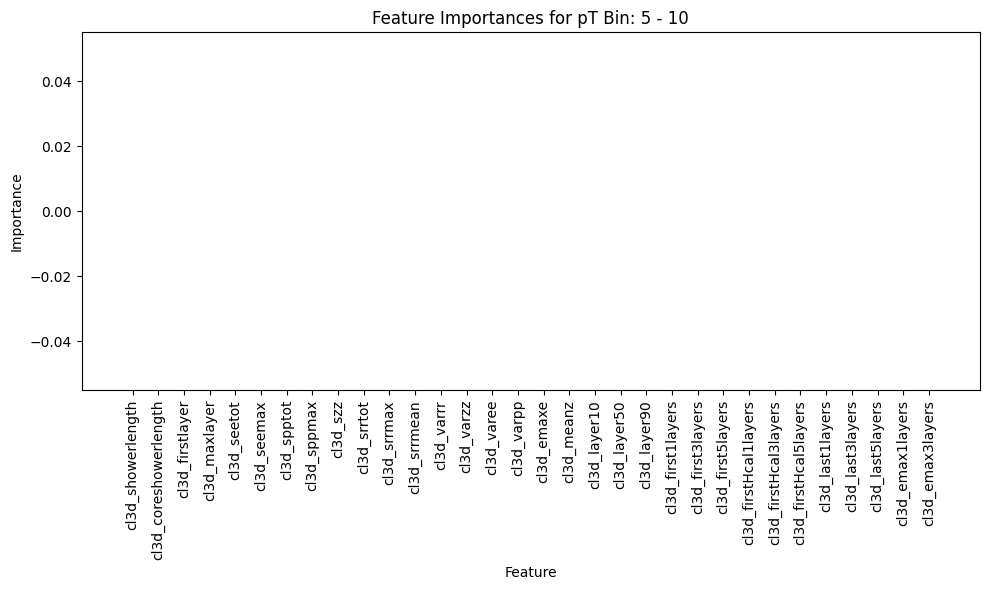

Training for pT bin: 10 - 20


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 10_importance_score.png


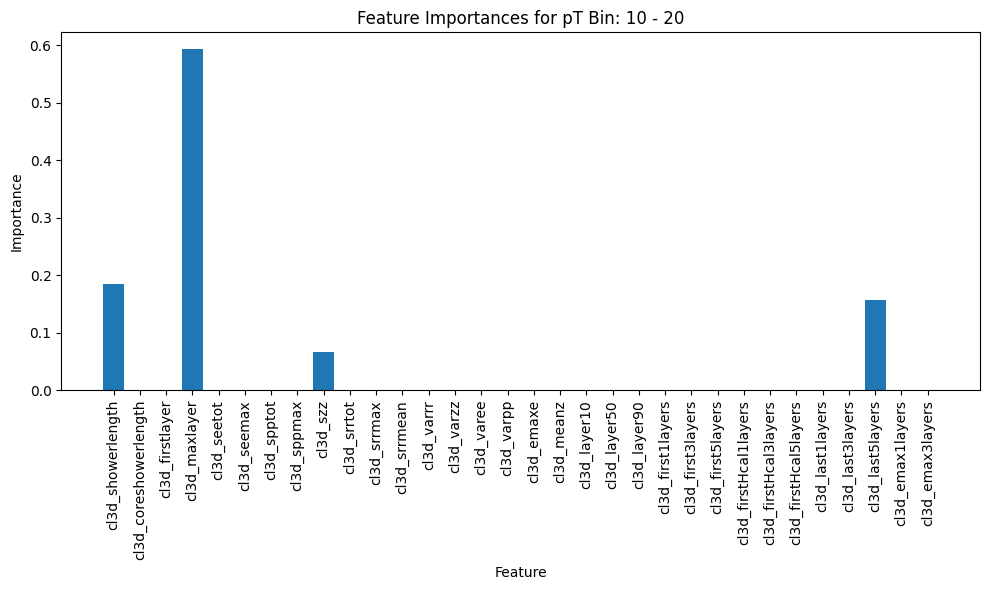

Training for pT bin: 20 - 50


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 20_importance_score.png


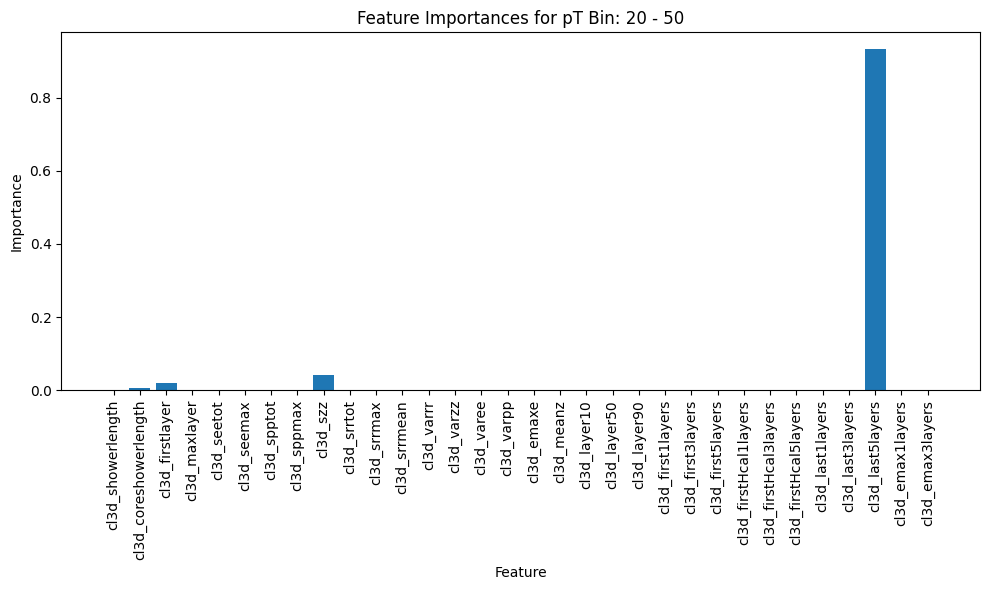

Training for pT bin: 50 - 100


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 50_importance_score.png


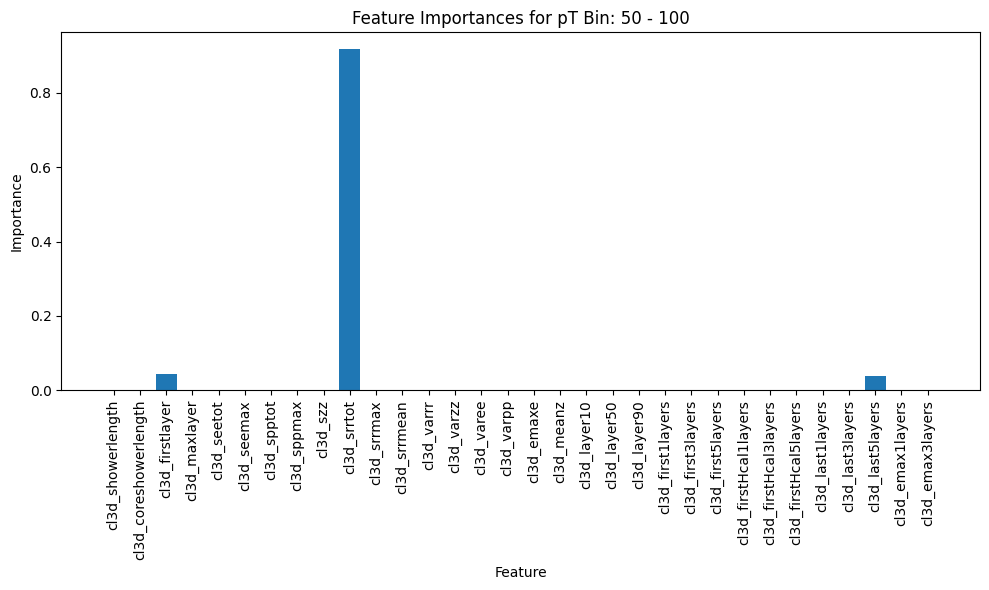

Training for pT bin: 100 - 200
Skipping bin 100 - 200 due to insufficient class diversity.


In [19]:
feature_importance_by_bin = {}

for pt_bin in range(len(pt_bins) - 1):  # Loop through bins
    print(f"Training for pT bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    
    # Filter data for the current bin
    bin_data = filtered_data[filtered_data['pt_bin'] == pt_bin]
    X = bin_data[columns_for_training]
    y = bin_data['label']
    
    # Check class balance
    class_counts = y.value_counts()
    if len(class_counts) < 2:  # Less than two classes present
        print(f"Skipping bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]} due to insufficient class diversity.")
        continue
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train XGBoost model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.001
    )
    model.fit(X_train, y_train)
    
    # Save feature importances
    feature_importances = model.feature_importances_
    feature_importance_by_bin[pt_bin] = feature_importances
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(columns_for_training, feature_importances)
    plt.xticks(rotation=90)
    plt.title(f"Feature Importances for pT Bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    filename = f"{pt_bins[pt_bin]}_importance_score.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")    
    plt.show()

Training for pT bin: 20 - 25


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 20_shap_summary.png


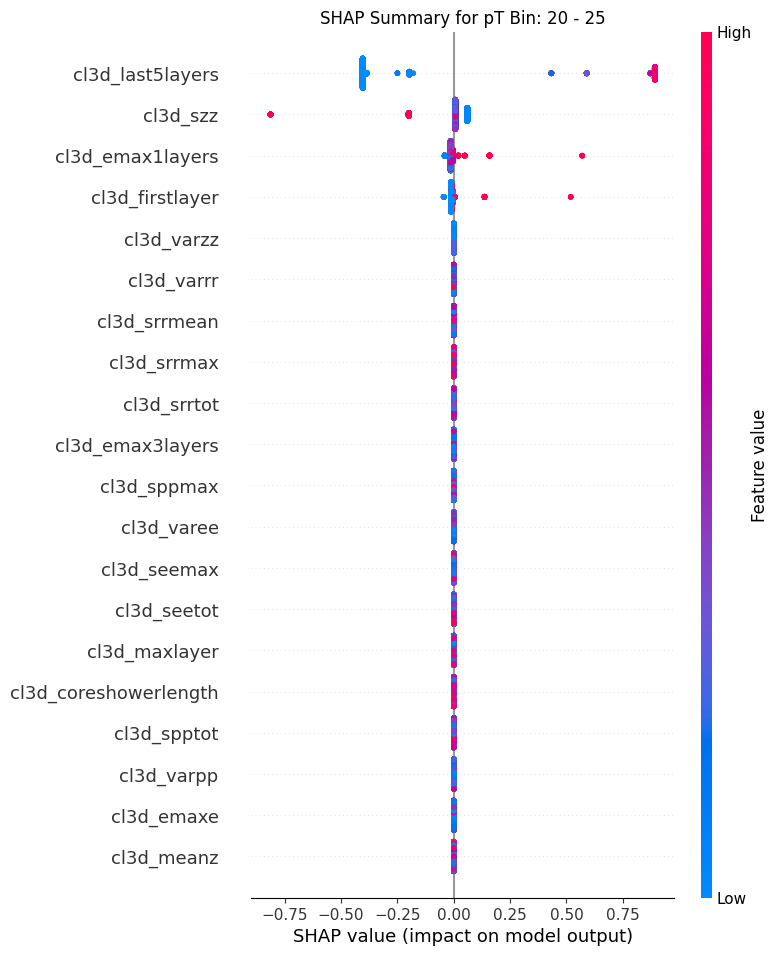

Saved: 20_shap_dependence_cl3d_showerlength.png


<Figure size 640x480 with 0 Axes>

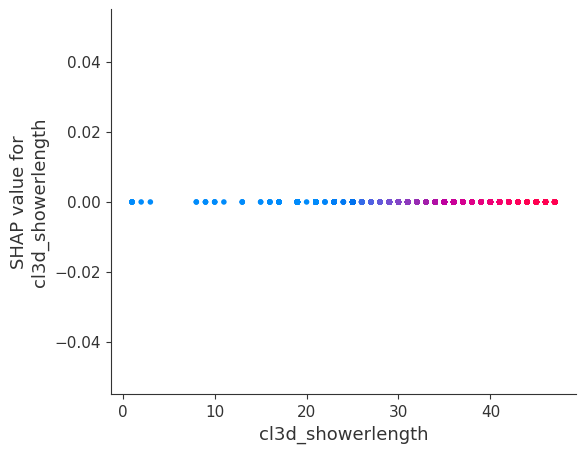

Saved: 20_shap_dependence_cl3d_coreshowerlength.png


<Figure size 640x480 with 0 Axes>

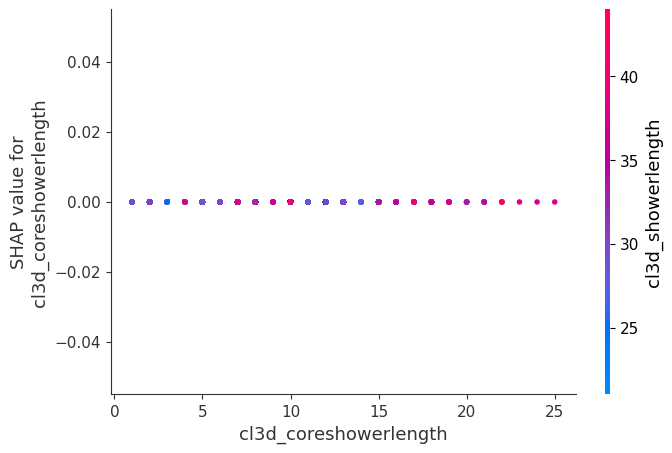

Saved: 20_shap_dependence_cl3d_firstlayer.png


<Figure size 640x480 with 0 Axes>

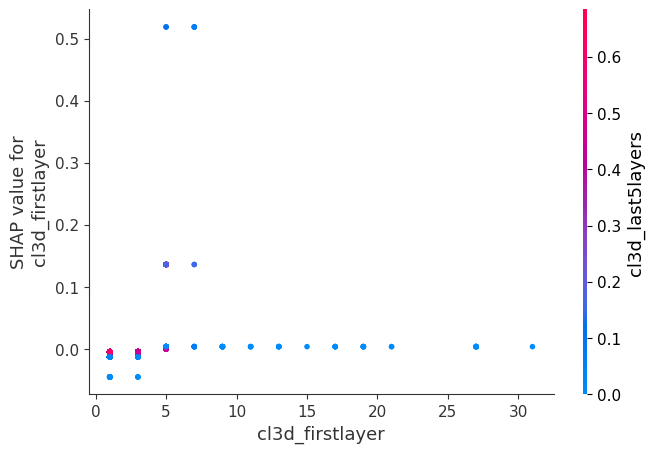

Training for pT bin: 25 - 30


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 25_shap_summary.png


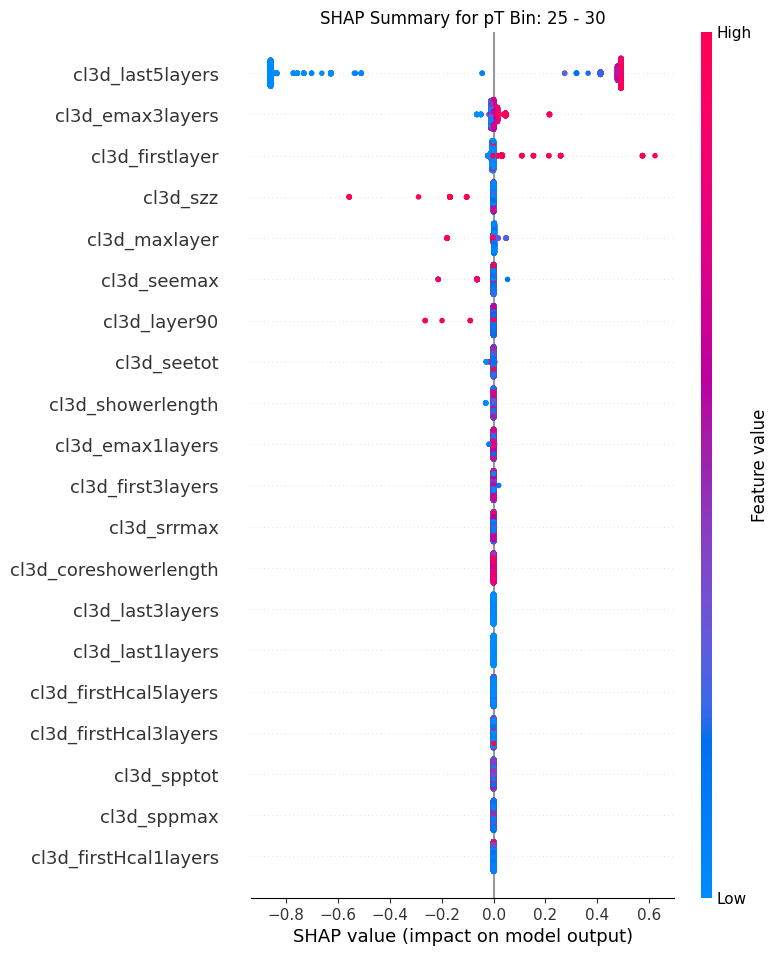

Saved: 25_shap_dependence_cl3d_showerlength.png


<Figure size 640x480 with 0 Axes>

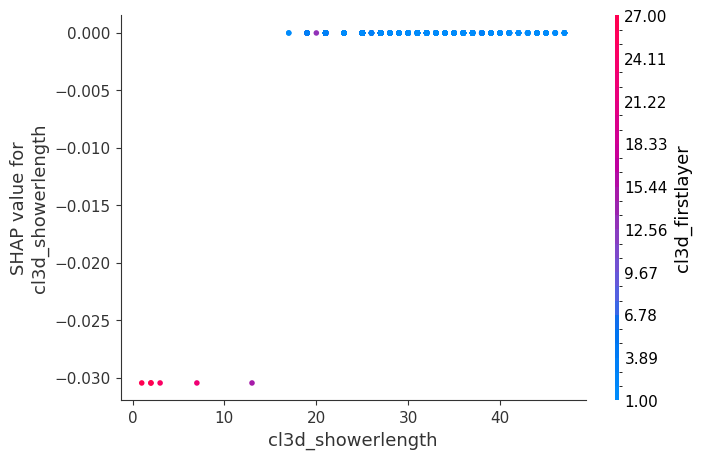

Saved: 25_shap_dependence_cl3d_coreshowerlength.png


<Figure size 640x480 with 0 Axes>

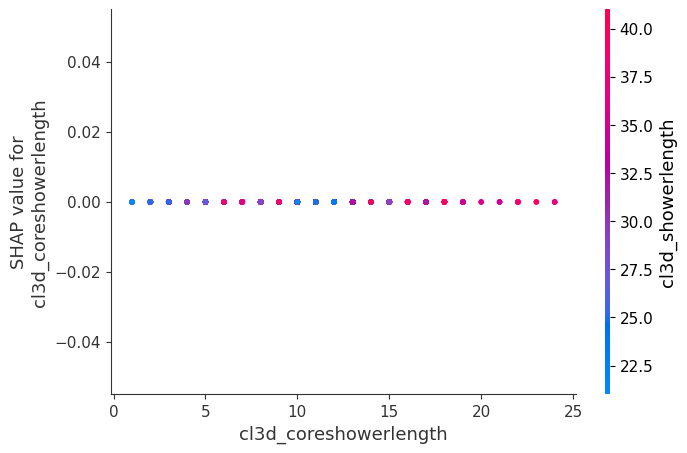

Saved: 25_shap_dependence_cl3d_firstlayer.png


<Figure size 640x480 with 0 Axes>

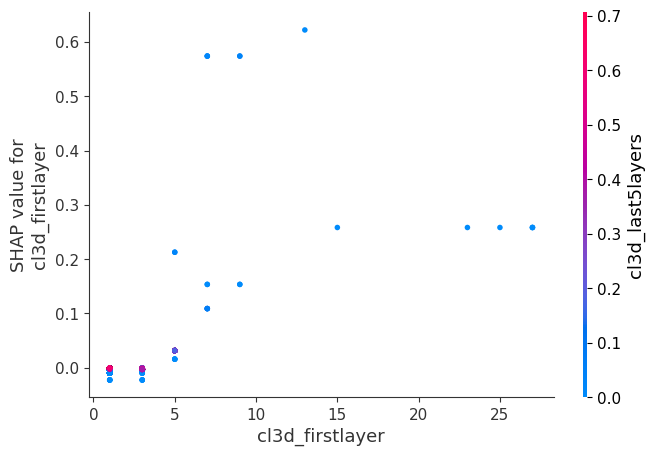

In [13]:
import shap  # Import SHAP library

# Define pT bins and process data
pt_bins = [20, 25, 30]  # Example bins
df_combined['pt_bin'] = pd.cut(df_combined['cl3d_pt'], bins=pt_bins, labels=False)

columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_firstHcal1layers',
    'cl3d_firstHcal3layers', 'cl3d_firstHcal5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

# Filter data for training
filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]
feature_importance_by_bin = {}
shap_values_by_bin = {}

for pt_bin in range(len(pt_bins) - 1):  # Loop through bins
    print(f"Training for pT bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    
    # Filter data for the current bin
    bin_data = filtered_data[filtered_data['pt_bin'] == pt_bin]
    X = bin_data[columns_for_training]
    y = bin_data['label']
    
    # Check class balance
    class_counts = y.value_counts()
    if len(class_counts) < 2:  # Less than two classes present
        print(f"Skipping bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]} due to insufficient class diversity.")
        continue
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train XGBoost model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.001
    )
    model.fit(X_train, y_train)
    
    # SHAP analysis
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    shap_values_by_bin[pt_bin] = shap_values

    # Generate SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Summary for pT Bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    filename = f"{pt_bins[pt_bin]}_shap_summary.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()
    
    # Generate SHAP dependence plots for the top features
    for feature in columns_for_training[:3]:  # Select the top 3 features for demonstration
        plt.figure()
        shap.dependence_plot(feature, shap_values.values, X_test, show=False)
        filename = f"{pt_bins[pt_bin]}_shap_dependence_{feature}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()


In [ ]:
def count_subentries(df, entry_column="event", subentry_column="gen_n"):
    # Count the number of subentries (e.g., gen_n) for each entry (e.g., event)
    subentry_counts = df.groupby(entry_column)[subentry_column].count()
    return subentry_counts

# Count subentries for signal and background
signal_subentries = count_subentries(signal_df)

# Create histograms for signal and background
plt.figure(figsize=(10, 6))

num_bins = 10
bins = np.linspace(min(signal_subentries),max(signal_subentries), num_bins)
# Plot the histograms
plt.hist(signal_subentries, bins=bins, alpha=0.5, label="Signal", color="blue", edgecolor="black")

# Labels and title
plt.xlabel('Number of Subentries per Entry')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Number of Subentries per Entry for Signal and Background')
plt.legend()

# Show the plot
plt.show()